In [1]:
import pandas as pd
import numpy as np
import os, sys, glob
from tqdm import tqdm
import datetime as dt

# Join Tables

In [40]:
df_citi = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/citi_df.csv')
df_weather = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/Weather.csv')
df_subway = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/Subway.csv')
df_event = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/Events_updated_v2.csv')
df_traffic = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/Traffic.csv')
df_theater = pd.read_csv('/Users/graceli/Documents/Baruch MSBA/S3/BUS9430/Data/FinalData/Theater.csv')

# df_subway.head()

In [607]:
df_citi.shape

(2973762, 7)

In [610]:
df_citi.head()

,Unnamed: 0,DateTime,Zipcode,StationID,BikeCount,Month,Hour
0,0,2017-01-01 00,10000,387,3,January,0
1,1,2017-01-01 00,10001,3259,2,January,0
2,2,2017-01-01 00,10001,388,2,January,0
3,3,2017-01-01 00,10001,442,3,January,0
4,4,2017-01-01 00,10001,466,1,January,0


In [ ]:
# df_citi.(['DateTime', 'Zipcode', 'Month','Hour']).agg({'BikeCount': ['sum']})

In [609]:
# df2_citi = df_citi.groupby(['DateTime', 'Zipcode']).agg({'BikeCount': ['sum']})
# df2_citi = df2_citi.reset_index()
# df2_citi.shape

(582410, 3)

In [7]:
df_citi['DateTime']=df_citi['DateTime'].str.slice(0, 10)
df1_citi = df_citi.groupby(['DateTime', 'Zipcode', 'Month','Hour']).agg({'BikeCount': ['sum']})
df1_citi = df1_citi.reset_index()

# df1_citi['Month'] = df_citi['DateTime'].str.slice(5, 7)
# df1_citi.head()

,DateTime,Zipcode,Month,Hour,BikeCount
,,,,,sum
0,2017-01-01,10000,January,0,3
1,2017-01-01,10000,January,1,8
2,2017-01-01,10000,January,2,2
3,2017-01-01,10000,January,4,1
4,2017-01-01,10000,January,5,1


In [8]:
df1_citi['Zipcode'] = df1_citi['Zipcode'].apply(lambda x: x.split('-')[0] if '-' in x else x)
df1_citi['Zipcode'] = df1_citi['Zipcode'].apply(lambda x: x[0] + x[2:] if len(x) ==6 else x)

In [9]:
df_wrongZipcode = df1_citi.loc[df1_citi['Zipcode'].str.len()>5,:]
df_wrongZipcode['Zipcode'].unique()

array([], dtype=object)

In [10]:
df1_citi['DateTime'] = pd.to_datetime(df1_citi['DateTime'], format='%Y-%m-%d')
df1_citi.dtypes

DateTime          datetime64[ns]
Zipcode                   object
Month                     object
Hour                       int64
BikeCount  sum             int64
dtype: object

## Create 'day of week' and 'Is_Holiday' variables

In [11]:
df1_citi['DayOfWeek'] = df1_citi['DateTime'].dt.day_name()
df1_citi.head()

,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek
,,,,,sum,
0,2017-01-01,10000,January,0,3,Sunday
1,2017-01-01,10000,January,1,8,Sunday
2,2017-01-01,10000,January,2,2,Sunday
3,2017-01-01,10000,January,4,1,Sunday
4,2017-01-01,10000,January,5,1,Sunday


In [12]:
from datetime import date

import holidays

us_holidays = holidays.CountryHoliday('US', prov=None, state='NY',years=[2017])

In [13]:
df1_citi['Holiday'] = df1_citi['DateTime'].isin(us_holidays)
df1_citi.head()

,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek,Holiday
,,,,,sum,,
0,2017-01-01,10000,January,0,3,Sunday,True
1,2017-01-01,10000,January,1,8,Sunday,True
2,2017-01-01,10000,January,2,2,Sunday,True
3,2017-01-01,10000,January,4,1,Sunday,True
4,2017-01-01,10000,January,5,1,Sunday,True


In [14]:
df1_citi.columns = df1_citi.columns.droplevel(1)
df1_citi.columns

Index(['DateTime', 'Zipcode', 'Month', 'Hour', 'BikeCount', 'DayOfWeek',
       'Holiday'],
      dtype='object')

In [15]:
df_weather = df_weather.loc[:,['temp','feels_like','pressure','humidity',
                               'wind_speed','weather_main','weather_description',
                               'date_ET','time_ET']]
df_weather.head()

,temp,feels_like,pressure,humidity,wind_speed,weather_main,weather_description,date_ET,time_ET
0,44.37,35.69,1013,52,8.05,Clouds,overcast clouds,2017-01-01,00:00:00
1,44.64,35.49,1013,54,9.17,Clouds,overcast clouds,2017-01-01,01:00:00
2,44.11,34.90,1013,54,9.17,Clouds,overcast clouds,2017-01-01,02:00:00
3,44.22,35.47,1013,51,8.05,Clouds,scattered clouds,2017-01-01,03:00:00
4,43.47,33.42,1014,52,10.29,Clear,sky is clear,2017-01-01,04:00:00


In [16]:
df_weather['time_ET']=df_weather['time_ET'].str.slice(0, 2)
df_weather['time_ET']=df_weather['time_ET'].astype(int)

In [17]:
df_weather['date_ET']=pd.to_datetime(df_weather['date_ET'], format='%Y-%m-%d')

In [18]:
df_citiWeather = pd.merge(df1_citi, df_weather,  how='left', left_on=['DateTime','Hour'], right_on = ['date_ET','time_ET'])


In [19]:
df_citiWeather.columns

Index(['DateTime', 'Zipcode', 'Month', 'Hour', 'BikeCount', 'DayOfWeek',
       'Holiday', 'temp', 'feels_like', 'pressure', 'humidity', 'wind_speed',
       'weather_main', 'weather_description', 'date_ET', 'time_ET'],
      dtype='object')

In [20]:
df_citiWeather=df_citiWeather.drop(['date_ET', 'time_ET'], axis=1)

In [22]:
df_subway['Zipcode'] = df_subway['Zipcode'].str.slice(0,5)
df_subway = df_subway.groupby(['Zipcode']).agg({'Objectid': ['count']})
df1_subway = df_subway.reset_index()
df1_subway.columns = df1_subway.columns.droplevel(1)

df1_subway.head()

,Zipcode,Objectid
0,10000,5
1,10001,43
2,10002,18
3,10003,26
4,10004,5


In [23]:
df_citiWeatherSub = pd.merge(df_citiWeather,df1_subway, how = 'left',left_on = ['Zipcode'],right_on=['Zipcode'])
df_citiWeatherSub = df_citiWeatherSub.rename(columns={"Objectid":"SubwayEntranceCount"})
df_citiWeatherSub.head()

,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek,Holiday,temp,feels_like,pressure,humidity,wind_speed,weather_main,weather_description,SubwayEntranceCount
0,2017-01-01,10000,January,0,3,Sunday,True,44.37,35.69,1013,52,8.05,Clouds,overcast clouds,5.0
1,2017-01-01,10000,January,1,8,Sunday,True,44.64,35.49,1013,54,9.17,Clouds,overcast clouds,5.0
2,2017-01-01,10000,January,2,2,Sunday,True,44.11,34.90,1013,54,9.17,Clouds,overcast clouds,5.0
3,2017-01-01,10000,January,4,1,Sunday,True,43.47,33.42,1014,52,10.29,Clear,sky is clear,5.0
4,2017-01-01,10000,January,5,1,Sunday,True,43.11,32.18,1015,48,11.41,Clear,sky is clear,5.0


In [24]:
df_event['time'] = df_event['time'].str.slice(0,10)
df_event['time'] = pd.to_datetime(df_event['time'], format='%Y-%m-%d')
df_event = df_event.rename(columns={'time':'date'})


In [25]:
df_event.head()

,Unnamed: 0,Zipcode,date,Special Event,Construction,Farmers Market,Sidewalk Sale,Parade,Production Event,Street Event,...,Theater Load in and Load Outs_01,Miscellaneous_01,Embargo_01,Street Festival_01,Athletic Race / Tour_01,Single Block Festival_01,Stickball_01,Weekend Walk_01,Shooting Permit_01,hour
0,0,10000,2017-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,10000,2017-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,10000,2017-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,3,10000,2017-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,4,10000,2017-01-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [26]:
df_event = df_event.drop(['Unnamed: 0'],axis=1)

In [27]:
df_event = df_event.astype({'Zipcode':str})
df_event.dtypes

Zipcode                                     object
date                                datetime64[ns]
Special Event                                int64
Construction                                 int64
Farmers Market                               int64
Sidewalk Sale                                int64
Parade                                       int64
Production Event                             int64
Street Event                                 int64
Plaza Event                                  int64
Block Party                                  int64
Religious Event                              int64
Theater Load in and Load Outs                int64
Miscellaneous                                int64
Embargo                                      int64
Street Festival                              int64
Athletic Race / Tour                         int64
Single Block Festival                        int64
Stickball                                    int64
Weekend Walk                   

In [28]:
df_citiWeatherSubEvent = pd.merge(df_citiWeatherSub,df_event, how='left',left_on=['DateTime','Zipcode','Hour'],right_on =['date','Zipcode','hour'])
df_citiWeatherSubEvent.head()


,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek,Holiday,temp,feels_like,pressure,...,Theater Load in and Load Outs_01,Miscellaneous_01,Embargo_01,Street Festival_01,Athletic Race / Tour_01,Single Block Festival_01,Stickball_01,Weekend Walk_01,Shooting Permit_01,hour
0,2017-01-01,10000,January,0,3,Sunday,True,44.37,35.69,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01,10000,January,1,8,Sunday,True,44.64,35.49,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2017-01-01,10000,January,2,2,Sunday,True,44.11,34.90,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,2017-01-01,10000,January,4,1,Sunday,True,43.47,33.42,1014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,2017-01-01,10000,January,5,1,Sunday,True,43.11,32.18,1015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
df_citiWeatherSubEvent.columns

In [29]:
df_citiWeatherSubEvent = df_citiWeatherSubEvent.drop(['date','hour'],axis=1)

In [41]:
df_theater = df_theater.groupby(['ZIP']).agg({'the_geom':['count']}).reset_index()
df_theater.head()

,ZIP,the_geom
,,count
0,0,1
1,10001,4
2,10002,2
3,10003,13
4,10009,3


In [42]:
df_theater.columns = df_theater.columns.droplevel(1)

,ZIP,the_geom
0,0,1
1,10001,4
2,10002,2
3,10003,13
4,10009,3


In [44]:
df_theater = df_theater.rename(columns={'the_geom':'no_theater'})
df_theater.iloc[0,0] = '10024'

In [88]:
df_citiWeatherSubEventTheater = pd.merge(df_citiWeatherSubEvent,df_theater, how='left',left_on=['Zipcode'],right_on =['ZIP'])
df_citiWeatherSubEventTheater['Zipcode'] = df_citiWeatherSubEventTheater['Zipcode'].astype(int)
df_citiWeatherSubEventTheater.drop('ZIP', axis=1, inplace=True)
df_citiWeatherSubEventTheater['no_theater'] = df_citiWeatherSubEventTheater['no_theater'].fillna(0) 
df_citiWeatherSubEventTheater.head()

,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek,Holiday,temp,feels_like,pressure,...,Theater Load in and Load Outs_01,Miscellaneous_01,Embargo_01,Street Festival_01,Athletic Race / Tour_01,Single Block Festival_01,Stickball_01,Weekend Walk_01,Shooting Permit_01,no_theater
0,2017-01-01,10000,January,0,3,Sunday,True,44.37,35.69,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-01-01,10000,January,1,8,Sunday,True,44.64,35.49,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-01-01,10000,January,2,2,Sunday,True,44.11,34.90,1013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-01,10000,January,4,1,Sunday,True,43.47,33.42,1014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-01,10000,January,5,1,Sunday,True,43.11,32.18,1015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df_traffic = df_traffic.loc[:,['Date','Time','Zipcode','Count']]

,Date,Time,Zipcode,Count
0,1/14/17,12:00-1:00 AM,10036,1286
1,1/14/17,1:00-2:00AM,10036,1061
2,1/14/17,2:00-3:00AM,10036,714
3,1/14/17,3:00-4:00AM,10036,531
4,1/14/17,4:00-5:00AM,10036,422


In [81]:
hourMapping = {'11:00-12:00AM' : 23,
               '4:00-5:00AM' : 4,
                '7:00-8:00AM':7,
                '9:00-10:00PM':21,
                '10:00-11:00AM':10,
                '5:00-6:00AM':5,
                '12:00-1:00PM':12,
                '4:00-5:00PM':16,
                '12:00-1:00 AM':0,
                '7:00-8:00PM':19,
                '2:00-3:00PM':14,
                '3:00-4:00AM':3,
                '11:00-12:00PM':11,
                '6:00-7:00PM':18,
                '1:00-2:00PM':13,
                '9:00-10:00AM':9,
                '6:00-7:00AM':6,
                '3:00-4:00PM':15,
                '8:00-9:00PM':20,
                 '8:00-9:00AM':8,
                '2:00-3:00AM':2,
                '1:00-2:00AM':1,
                '10:00-11:00PM':22,
                '5:00-6:00PM':17}
    
df_traffic['Hour'] = df_traffic['Time'].map(hourMapping)
df_traffic['DateTime'] = pd.to_datetime(df_traffic['Date'])

In [199]:
df_citiWeatherSubEventTheaterTraffic = pd.merge(df_citiWeatherSubEventTheater,
                                                df_traffic[['DateTime','Hour','Zipcode', 'Count']].rename({'Count':'TrafficCount'}, axis=1),
                                                on = ['DateTime','Hour','Zipcode'])

In [94]:
print(df_citiWeatherSubEventTheater.shape,
      df_citiWeatherSubEventTheaterTraffic.shape)

print( len(df_citiWeatherSubEventTheater['DateTime'].value_counts()) )
print( len(df_citiWeatherSubEventTheaterTraffic['DateTime'].value_counts()) )


(582410, 54) (43234, 62)
361
89


In [161]:
# df_citiWeatherSubEventTheater.groupby(['weather_main', 'weather_description'])['Zipcode'].count()
# df_citiWeatherSubEventTheater['weather_description']


# df_citiWeatherSubEventTheater.isnull().sum(0)
# df_citiWeatherSubEventTheater.fillna(0).isnull().sum(0)
# colDtypes = dfReg.dtypes
# dfReg.dtypes.drop('BikeCount')
# colDtypes
# colDtypes = dfReg.dtypes.drop(['BikeCount', 'Zipcode', 'Holiday'])
# numericalCols = colDtypes[(colDtypes == np.float) | (colDtypes == np.int)].index.values
# numericalCols

DateTime                            datetime64[ns]
Month                                       object
Hour                                      category
DayOfWeek                                   object
temp                                       float64
feels_like                                 float64
pressure                                     int64
humidity                                     int64
wind_speed                                 float64
weather_main                                object
weather_description                         object
SubwayEntranceCount                        float64
Special Event                              float64
Construction                               float64
Farmers Market                             float64
Sidewalk Sale                              float64
Parade                                     float64
Production Event                           float64
Street Event                               float64
Plaza Event                    

# Modeling
To keep traffic data, we need to inner join the tables, which reduce the number of samples significantly.
## Step 1: Evaluate if the traffic data contribute to our prediction.
### Use OLS to compare the R-squared with and without traffic data, based on the smaller sized samples.
The R-squared does not improve a lot, by 0.2% only. 
## Conclusion: Use the larger joined data without traffic.

In [532]:
# With traffic
import statsmodels.api as sm
def genRegX(df, dropNumericalCols = []):
    return pd.concat([df[np.setdiff1d(numericalCols, dropNumericalCols)], 
                      pd.get_dummies(df[catCols], drop_first=True)], axis=1)
mse = lambda a, b : np.mean((a-b)**2)
R2 = lambda a, b: 1 - mse(a,b) / np.mean( (b - np.mean(b)) **2)
events = np.array(['Special Event', 'Construction', 'Farmers Market', 'Sidewalk Sale',
                   'Parade', 'Production Event', 'Street Event', 'Plaza Event',
                   'Block Party', 'Religious Event', 'Theater Load in and Load Outs',
                   'Miscellaneous', 'Street Festival',
                   'Athletic Race / Tour', 'Single Block Festival', 'Stickball',
                   'Weekend Walk', 'Shooting Permit'])
dfReg = df_citiWeatherSubEventTheaterTraffic.copy().fillna(0).drop(['no_theater', 'SubwayEntranceCount', 'Embargo', 'Embargo_01'], axis=1)
dfReg['log10(BikeCount)'] = np.log10(dfReg['BikeCount'])
yCol = 'log10(BikeCount)'

discardEvents = [event for event in events if (dfReg[event] > 0).mean() < 0.02]
discardEvents += ([event + '_01' for event in discardEvents])
# discardEvents = []

dfReg['Holiday'] = dfReg['Holiday'].astype(int)
dfReg['Hour'] = dfReg['Hour'].astype('category')
dfReg['Zipcode'] = dfReg['Zipcode'].astype('category')

colDtypes = dfReg.dtypes.drop(['BikeCount', 'log10(BikeCount)', 'Zipcode', 'Hour'])
numericalCols = colDtypes[(colDtypes == np.float) | (colDtypes == np.int)].index.values
numericalCols = np.setdiff1d(numericalCols, discardEvents)
dfReg[numericalCols] = (dfReg[numericalCols] - dfReg[numericalCols].mean()) / dfReg[numericalCols].std()
catCols = ['Zipcode', 'Month', 'Hour', 'DayOfWeek', 'weather_description']

dfReg['intercept'] = 1
numericalCols = np.concatenate((['intercept'], numericalCols))


## Train-test split to evaluate TrafficCount
np.random.seed(10)
testProp = 0.2
testIdx = np.random.choice(np.arange(len(dfReg)), int(len(dfReg) * testProp), replace=False)
trainIdx = np.setdiff1d(np.arange(len(dfReg)), testIdx)
dfRegTrain, dfRegTest = dfReg.iloc[trainIdx, :], dfReg.iloc[testIdx, :]
print("Train samples %d. Test samples %d" % (len(dfRegTrain), len(dfRegTest)) )

olsTrain = sm.OLS(dfRegTrain[yCol], genRegX(dfRegTrain)).fit()
olsTrainNoTraffic = sm.OLS(dfRegTrain[yCol], genRegX(dfRegTrain, 'TrafficCount') ).fit()

yhat = olsTrain.predict(genRegX(dfRegTest))
yhatNoTraffic = olsTrainNoTraffic.predict(genRegX(dfRegTest, 'TrafficCount'))
print("Test data. With traffic: MSE %.4f, R^2 %.5f. No traffic: MSE %.4f, R^2 %.5f" % 
      ( mse(yhat, dfRegTest[yCol]), R2(yhat, dfRegTest[yCol]),
        mse(yhatNoTraffic, dfRegTest[yCol]), R2(yhatNoTraffic, dfRegTest[yCol]) )  )

print(olsTrain.summary())
##


# Simple regression, lasson, Ridge
# df_citiWeatherSubEventTheater.columns

Train samples 34588. Test samples 8646
Test data. With traffic: MSE 0.1399, R^2 0.65401. No traffic: MSE 0.1408, R^2 0.65196
                            OLS Regression Results                            
Dep. Variable:       log10(BikeCount)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     577.0
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:30:08   Log-Likelihood:                -15243.
No. Observations:               34588   AIC:                         3.071e+04
Df Residuals:                   34477   BIC:                         3.165e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t| 

## Step 2: Run OLS, Lasso, and Ridge regressions, and select the best one
### Feature engineering:
#### 1. Discarded events with minimal instances
#### 2. Discarded subway data because of multicolinearity (there was a warning of multicolinearity when leaving subway data in the model)
#### 3. Discuarded theater data because of minimal instances
#### 4. Get dummies for categorical variables
#### 5. Log transformed Y, because of non-negativity nature of the number of bikes/trips
#### 6. For OLS, standardized ((x-mean of x)/standard deviation) continuous variables, because of the large variance of scales among variables, (warning: condition number too large, numerical precision problem regarding the coefficients)
#### 7. For Lasso and Ridge, standardize all variables, which is required for fitting these types of models.

## Conclusion: Lasso and Ridge are not significantly better, they both suggested not to penalize any variables. We should stick to OLS, since it's easier to interpret.

In [566]:
# No traffic, all data
import statsmodels.api as sm
events = np.array(['Special Event', 'Construction', 'Farmers Market', 'Sidewalk Sale',
                   'Parade', 'Production Event', 'Street Event', 'Plaza Event',
                   'Block Party', 'Religious Event', 'Theater Load in and Load Outs',
                   'Miscellaneous', 'Street Festival',
                   'Athletic Race / Tour', 'Single Block Festival', 'Stickball',
                   'Weekend Walk', 'Shooting Permit'])
dfReg = df_citiWeatherSubEventTheater.copy().fillna(0).drop(['no_theater', 'SubwayEntranceCount', 'Embargo', 'Embargo_01'], axis=1)
dfReg['log10(BikeCount)'] = np.log10(dfReg['BikeCount'])
yCol = 'log10(BikeCount)'
discardEvents = [event for event in events if (dfReg[event] > 0).mean() < 0.02]
discardEvents += ([event + '_01' for event in discardEvents])
# discardEvents = []

dfReg['Holiday'] = dfReg['Holiday'].astype(int)
dfReg['Hour'] = dfReg['Hour'].astype('category')
dfReg['Zipcode'] = dfReg['Zipcode'].astype('category')

colDtypes = dfReg.dtypes.drop(['BikeCount', 'log10(BikeCount)', 'Zipcode', 'Hour'])
numericalCols = colDtypes[(colDtypes == np.float) | (colDtypes == np.int)].index.values
numericalCols = np.setdiff1d(numericalCols, discardEvents)
dfRegNumericalColMean, dfRegNumericalColStd = dfReg[numericalCols].mean(), dfReg[numericalCols].std()
dfReg[numericalCols] = (dfReg[numericalCols] - dfRegNumericalColMean) / dfRegNumericalColStd
catCols = ['Zipcode', 'Month', 'Hour', 'DayOfWeek', 'weather_description']

dfReg['intercept'] = 1
numericalCols = np.concatenate((['intercept'], numericalCols))

## Train-test split to evaluate TrafficCount
np.random.seed(10)
testProp = 0.2
testIdx = np.random.choice(np.arange(len(dfReg)), int(len(dfReg) * testProp), replace=False)
trainIdx = np.setdiff1d(np.arange(len(dfReg)), testIdx)
dfRegTrain, dfRegTest = dfReg.iloc[trainIdx, :], dfReg.iloc[testIdx, :]
print("Train samples %d. Test samples %d" % (len(dfRegTrain), len(dfRegTest)) )

olsTrain = sm.OLS(dfRegTrain[yCol], genRegX(dfRegTrain)).fit()
yhat = olsTrain.predict(genRegX(dfRegTest))
print("Test data. MSE %.4f, R^2 %.5f" % 
      ( mse(yhat, dfRegTest[yCol]), R2(yhat, dfRegTest[yCol])) )

print(olsTrain.summary())

# Y: 'BikeCount'
# Hour and Zipcode to be factorized
# Simple regression, lasson, Ridge
# df_citiWeatherSubEventTheater.columns

Train samples 465928. Test samples 116482
Test data. MSE 0.1316, R^2 0.66409
                            OLS Regression Results                            
Dep. Variable:       log10(BikeCount)   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     6436.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:32:19   Log-Likelihood:            -1.8788e+05
No. Observations:              465928   AIC:                         3.761e+05
Df Residuals:                  465782   BIC:                         3.777e+05
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [592]:
# Drop variables with coefficient p-value > 0.1
dropCol = ['Farmers Market','Plaza Event_01','Theater Load in and Load Outs','Zipcode_10075','Month_August','weather_description_mist']
olsTrain2 = sm.OLS(dfRegTrain[yCol], 
                   genRegX(dfRegTrain).drop(dropCol, axis=1)).fit()
olsTrain2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log10(BikeCount)   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     6714.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:36:06   Log-Likelihood:            -1.8788e+05
No. Observations:              465928   AIC:                         3.760e+05
Df Residuals:                  465788   BIC:                         3.776e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Construction                                -0.0056      0.001     -7.753      0.000      -0.007      -0.004
Construction_01                              0.0085      0.001     10.212      0.000       0.007       0.010
Farmers Market_01                            0.0045      0.001      7.225      0.000       0.003       0.006
Holiday                                     -0.0213      0.001    -37.808      0.000      -0.022      -0.020
Plaza Event                                 -0.0052      0.001     -7.139      0.000      -0.007      -0.004
Production Event                             0.0026      0.001      3.821      0.000       0.001       0.004
Production Event_01                          0.0039      0.001      5.944      0.000       0.003       0.005
Special Event                                0.0046      0.001      6.429      0.000       0.003       0.006
Special Event_01                             0.0052      0.001      7.588      0.000       0.004       0.007
Street Event                                -0.0112      0.001     -9.919      0.000      -0.013      -0.009
Street Event_01                              0.0033      0.001      4.725      0.000       0.002       0.005
Theater Load in and Load Outs_01             0.0059      0.001      6.839      0.000       0.004       0.008
feels_like                                  -0.3083      0.009    -32.725      0.000      -0.327      -0.290
humidity                                    -0.0206      0.001    -18.610      0.000      -0.023      -0.018
intercept                                    0.3108      0.006     56.164      0.000       0.300       0.322
pressure                                     0.0115      0.001     18.484      0.000       0.010       0.013
temp                                         0.4515      0.009     48.747      0.000       0.433       0.470
wind_speed                                  -0.0510      0.001    -45.646      0.000      -0.053      -0.049
Zipcode_10001                                0.7851      0.006    130.128      0.000       0.773       0.797
Zipcode_10002                                0.5605      0.005    109.338      0.000       0.550       0.571
Zipcode_10003                                0.8966      0.007    132.861      0.000       0.883       0.910
Zipcode_10004                               -0.4631      0.013    -35.386      0.000      -0.489      -0.437
Zipcode_10005                                0.3963      0.006     64.646      0.000       0.384       0.408
Zipcode_10007                                0.7134      0.006    117.763      0.000       0.702       0.725
Zipcode_10009                                1.0884      0.006    194.693      0.000       1.077       1.099
Zipcode_10010                  

In [536]:
# Find optimal penalty for Lasso
from sklearn.linear_model import LassoCV
lassoCV = LassoCV(alphas=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3], fit_intercept=True, cv = 5, normalize=True, 
                  n_jobs = 2, verbose=True, random_state=100, max_iter = 5000, selection='random')
lassoFit = lassoCV.fit(genRegX(dfRegTrain), dfRegTrain[yCol])
print(lassoFit.alpha_)
print(lassoFit.alphas, lassoFit.mse_path_.sum(1))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
.........................[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   12.2s finished


1e-07
[1.99999051 1.60059533 0.73302804 0.685116   0.67714217]


In [537]:
# Find optimal penalty for Ridge
from sklearn.linear_model import RidgeCV
ridgeCV = RidgeCV(alphas=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3], fit_intercept=True, 
                  normalize=True, store_cv_values=True)
ridgeFit = ridgeCV.fit(genRegX(dfRegTrain), dfRegTrain[yCol])
print(ridgeFit.alpha_)
print(ridgeFit.alphas, ridgeFit.cv_values_.mean(0))

1e-06
[1.e-07 1.e-06 1.e-05 1.e-04 1.e-03] [0.13123152 0.13123152 0.13123153 0.13123328 0.13131181]


In [567]:
# Compare MSE and R^2 for OLS, Lasso and Ridge
yhatTrainOLS, yhatTestOLS = olsTrain.predict(genRegX(dfRegTrain)), olsTrain.predict(genRegX(dfRegTest))
yhatTrainLasso, yhatTestLasso = lassoFit.predict(genRegX(dfRegTrain)), lassoFit.predict(genRegX(dfRegTest))
yhatTrainRidge, yhatTestRidge = ridgeFit.predict(genRegX(dfRegTrain)), ridgeFit.predict(genRegX(dfRegTest))
print("OLS: Train MSE %.6f, R^2 %.5f. Test MSE %.6f, R^2 %.5f" % 
      (mse(yhatTrainOLS, dfRegTrain[yCol]), R2(yhatTrainOLS, dfRegTrain[yCol]),
       mse(yhatTestOLS, dfRegTest[yCol]), R2(yhatTestOLS, dfRegTest[yCol]),))
print("Lasso: Train MSE %.6f, R^2 %.5f. Test MSE %.6f, R^2 %.5f" % 
      (mse(yhatTrainLasso, dfRegTrain[yCol]), R2(yhatTrainLasso, dfRegTrain[yCol]),
       mse(yhatTestLasso, dfRegTest[yCol]), R2(yhatTestLasso, dfRegTest[yCol]),))
print("Ridge: Train MSE %.6f, R^2 %.5f. Test MSE %.6f, R^2 %.5f" % 
      (mse(yhatTrainRidge, dfRegTrain[yCol]), R2(yhatTrainRidge, dfRegTrain[yCol]),
       mse(yhatTestRidge, dfRegTest[yCol]), R2(yhatTestRidge, dfRegTest[yCol]),))


OLS: Train MSE 0.131153, R^2 0.66707. Test MSE 0.131635, R^2 0.66409
Lasso: Train MSE 0.131165, R^2 0.66704. Test MSE 0.131639, R^2 0.66408
Ridge: Train MSE 0.131153, R^2 0.66707. Test MSE 0.131635, R^2 0.66409


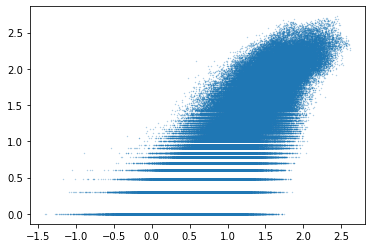

In [551]:
plt.scatter(yhatTrainOLS, dfRegTrain['log10(BikeCount)'],s=0.1,alpha=0.5)
# plt.scatter(np.power(10, yhatTrainOLS), dfRegTrain['BikeCount'],s=0.1,alpha=0.5)

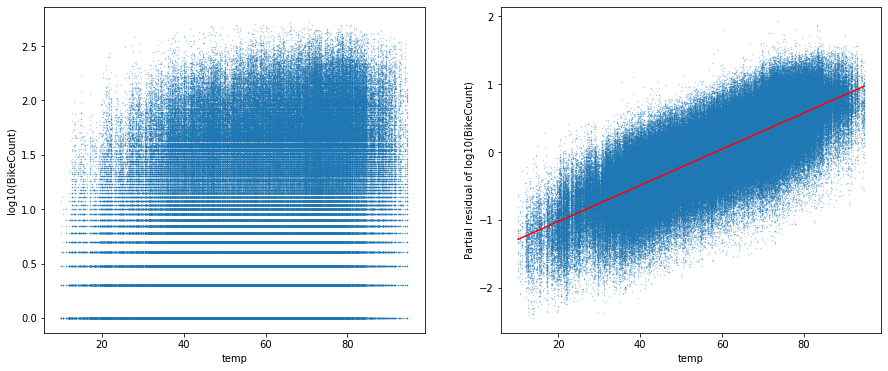

In [585]:
residual = dfRegTrain[yCol]-yhatTrainOLS
Xcol = 'temp'
Xval = dfRegTrain[Xcol] * dfRegNumericalColStd[Xcol] + dfRegNumericalColMean[Xcol]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.scatter(Xval, dfRegTrain[yCol], s=0.1,alpha=0.5)
plt.xlabel(Xcol);  plt.ylabel(yCol)

plt.subplot(1,2,2)
plt.scatter(Xval, residual + olsTrain.params[Xcol] * dfRegTrain[Xcol], 
            s=0.1,alpha=0.5)
plt.plot( [Xval.min(), Xval.max()], 
         [olsTrain.params[Xcol] * dfRegTrain[Xcol].min(), 
          olsTrain.params[Xcol] * dfRegTrain[Xcol].max()], color='red' )
plt.xlabel(Xcol);  plt.ylabel('Partial residual of %s' % yCol)
plt.show()

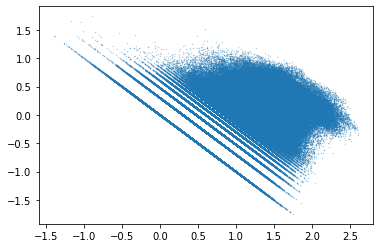

In [556]:
plt.scatter(yhatTrainOLS, dfRegTrain[yCol]-yhatTrainOLS,s=0.1,alpha=0.5)

In [602]:
len(df1_citi['Zipcode'].unique())

75

In [604]:
df1_citi.loc[df1_citi['Zipcode']=='99999',:]

,DateTime,Zipcode,Month,Hour,BikeCount,DayOfWeek,Holiday
44647,2017-01-30,99999,January,17,1,Monday,False
44648,2017-01-30,99999,January,19,1,Monday,False


In [605]:
74*24*361

641136

In [606]:
len(df1_citi)

582410